MC Advantage Actor Critic(A2C) Cartpole-v1 environment

(Some tricks)
- Return target(MC)
- Different learning rate of Actor and Critic network (Actor : 1e-4, Critic : 3e-3) <- 과도한 policy update 방지

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
class A2C(nn.Module):
    def __init__(self):
        super(A2C, self).__init__()
        self.fc1 = nn.Linear(4,512)
        self.fc_pi = nn.Linear(512,2)
        self.fc2 = nn.Linear(4,512)
        self.fc_v = nn.Linear(512,1)
        self.actor_optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.value_optimizer = optim.Adam(self.parameters(), lr=0.003)
        
    def forward(self, x):
        x_pi = F.relu(self.fc1(x))
        policy = F.softmax(self.fc_pi(x_pi), dim=0)
        x_v = F.relu(self.fc2(x))
        v = self.fc_v(x_v)
        return policy, v
        
    def train(self, actor_loss, value_loss):
        actor_loss = actor_loss.mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_loss_list = []
        
        value_loss = value_loss.mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        self.value_loss_list = []

In [3]:
env = gym.make('CartPole-v1')
model = A2C()
model.cuda()
GAMMA = 0.99

In [4]:
def make_return(r_list):
    G_list = []
    temp_G = 0.0
    for R in r_list[::-1]:
        temp_G *= GAMMA
        temp_G += R
        G_list.append(temp_G)
    G_list.reverse()
    return G_list

def make_loss_and_training(s_list, p_list, g_list, a_list, r_list):
    s_tensor = torch.cat(s_list, dim=0)
    r = torch.tensor(r_list, dtype=torch.float).reshape(-1,1).cuda()
    pi = torch.cat(p_list, dim=0)
    g = torch.tensor(g_list, dtype=torch.float).reshape(-1,1).cuda()
    
    values = model(s_tensor)[1]
    cur_value = values[:-1]
    next_value = values[1:]
    td_error = r + GAMMA*next_value - cur_value
    actor_loss = -torch.log(pi.gather(1, torch.tensor(a_list).cuda().reshape(-1,1)))*td_error.detach()
    critic_loss = (g-cur_value).pow(2)
    
    model.train(actor_loss, critic_loss)

In [5]:
reward_sum = 0.0
reward_list = []

for ep in range(2000):
    s_list, p_list, r_list, a_list = [], [], [], []
    observation = env.reset()
    state = torch.tensor(observation, dtype=torch.float).cuda()
    while True:
        policy, value = model(state)
        action = Categorical(policy).sample()
        observation, reward, done, _ = env.step(action.item())
        reward_sum += reward
        s_list.append(state.unsqueeze(0))
        p_list.append(policy.unsqueeze(0))
        r_list.append(reward)
        a_list.append(action)
        state = torch.tensor(observation, dtype=torch.float).cuda()
        if done:
            break
    s_list.append(state.unsqueeze(0))
    g_list = make_return(r_list)
    make_loss_and_training(s_list, p_list, g_list, a_list, r_list)
    
    if ep % 100 == 99:
        print('Episode %d'%ep,', Reward mean : %f'%(reward_sum/100.0))
        reward_list.append(reward_sum/100.0)
        #plt.plot(reward_list)
        #plt.show()
        reward_sum = 0.0
env.close()

Episode 99 , Reward mean : 18.030000
Episode 199 , Reward mean : 24.930000
Episode 299 , Reward mean : 40.770000
Episode 399 , Reward mean : 58.990000
Episode 499 , Reward mean : 66.850000
Episode 599 , Reward mean : 98.810000
Episode 699 , Reward mean : 147.900000
Episode 799 , Reward mean : 168.450000
Episode 899 , Reward mean : 172.420000
Episode 999 , Reward mean : 217.570000
Episode 1099 , Reward mean : 271.750000
Episode 1199 , Reward mean : 309.880000
Episode 1299 , Reward mean : 336.330000
Episode 1399 , Reward mean : 380.090000
Episode 1499 , Reward mean : 388.680000
Episode 1599 , Reward mean : 432.430000
Episode 1699 , Reward mean : 432.210000
Episode 1799 , Reward mean : 464.880000
Episode 1899 , Reward mean : 475.930000
Episode 1999 , Reward mean : 459.840000


Learning curve

mean reward every 100 episodes

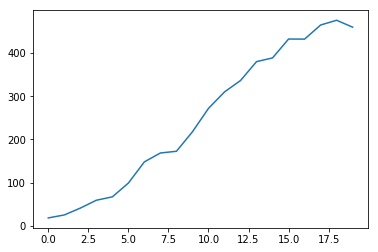

In [6]:
plt.plot(reward_list)
plt.show()

Test Rendering

In [7]:
for ep in range(10):
    observation = env.reset()
    while True:
        time.sleep(0.05)
        env.render()

        state = torch.tensor(observation, dtype=torch.float).cuda()
        policy, value = model(state)
        action = Categorical(policy).sample()
        observation, reward, done, _ = env.step(action.item())
        if done: break
env.close()

- Reference

https://github.com/seungeunrho/minimalRL

https://github.com/rgilman33/simple-A2C/blob/master/2_A2C-nstep.ipynb

https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py